Для начала необходимо оценить вид распределения данных, чтобы принять решение о выборе моделию Для этого проведём Q-Q тесты для каждого признака

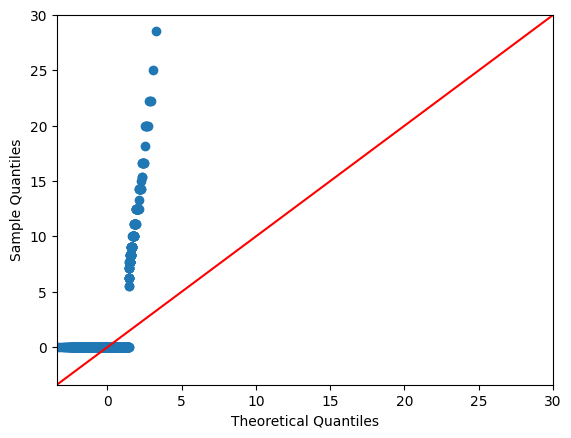

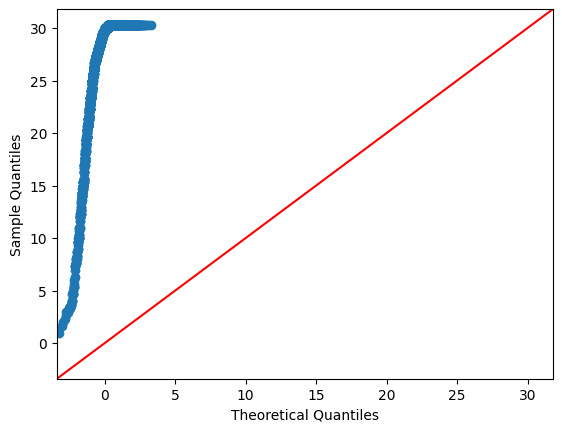

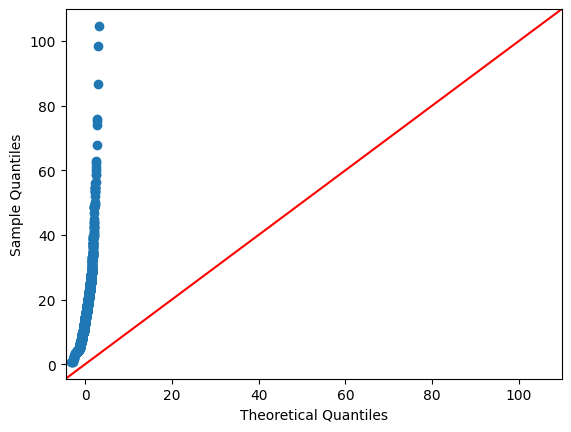

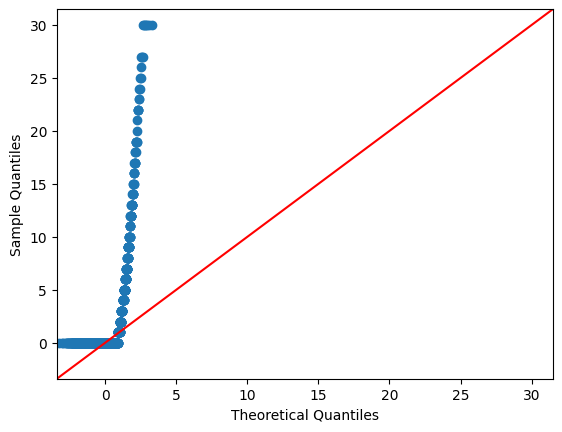

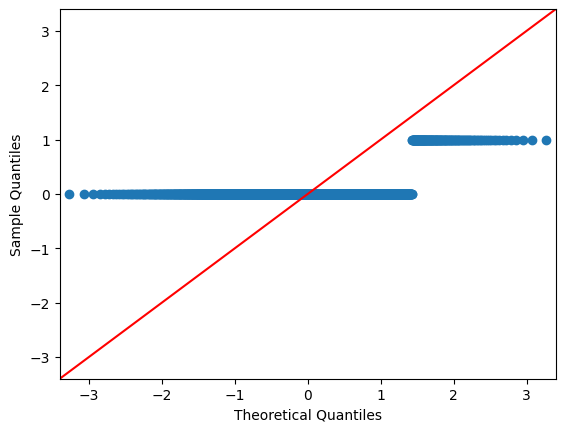

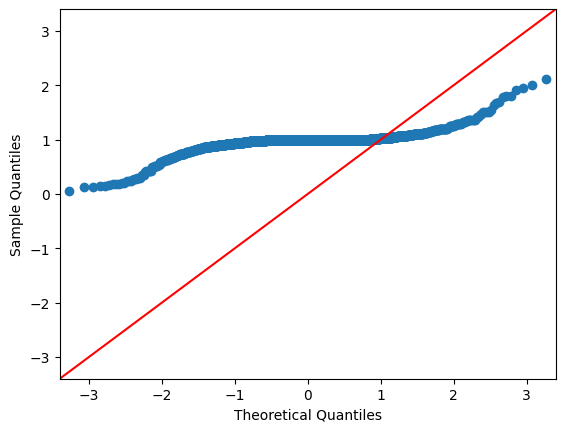

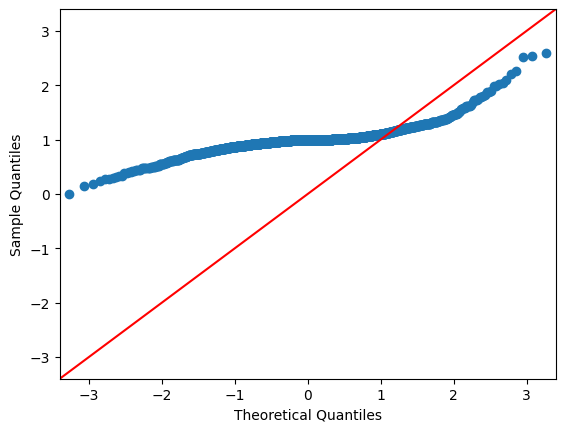

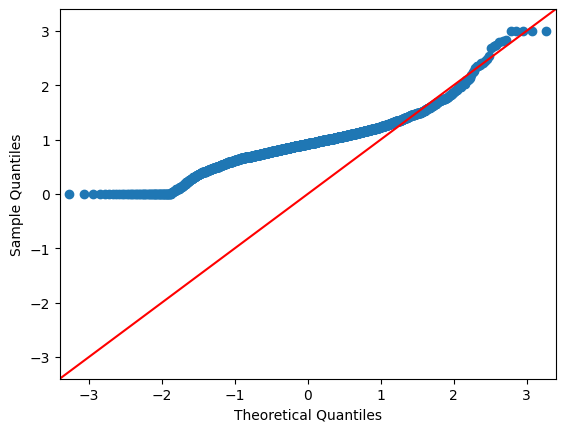

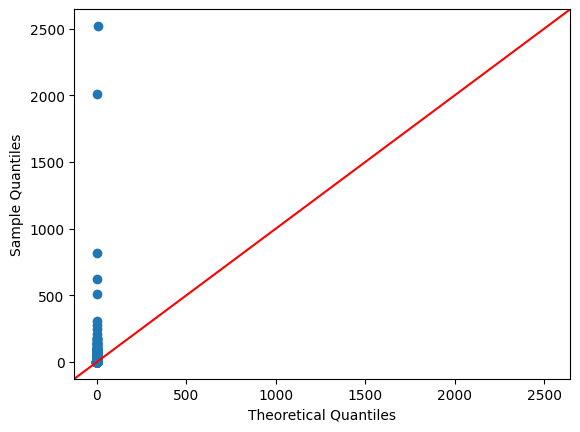

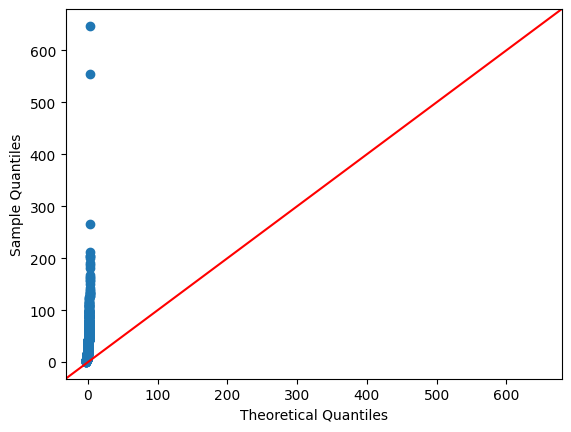

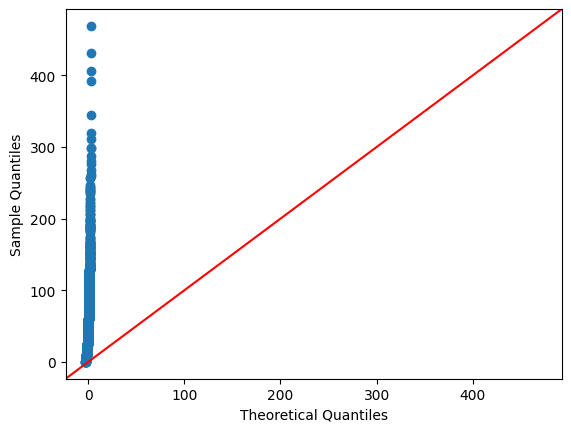

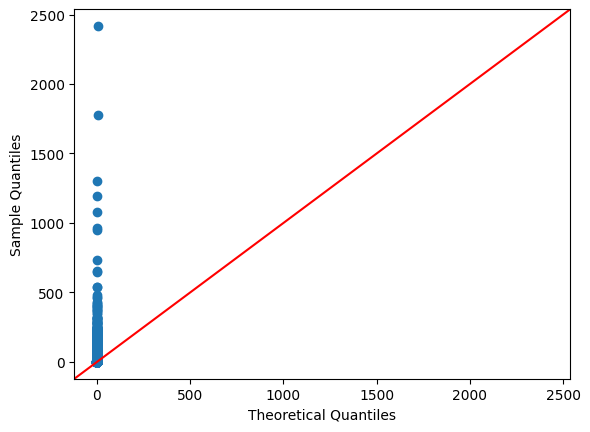

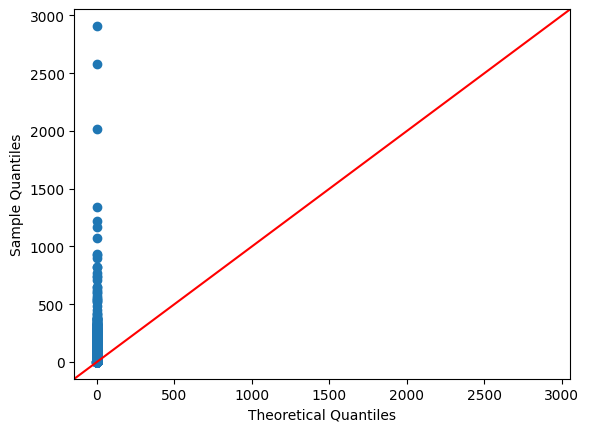

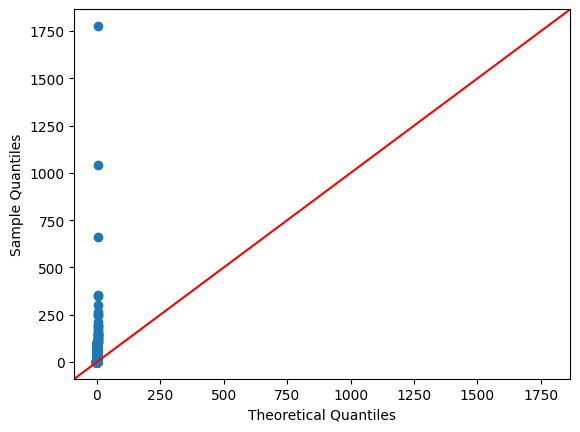

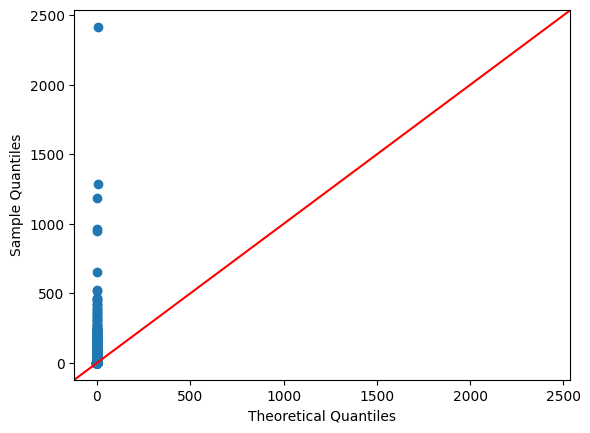

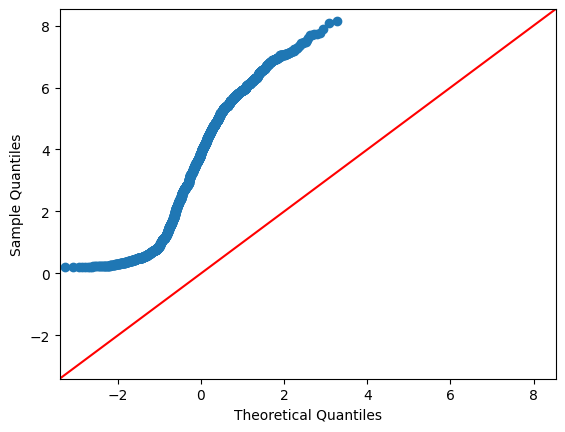

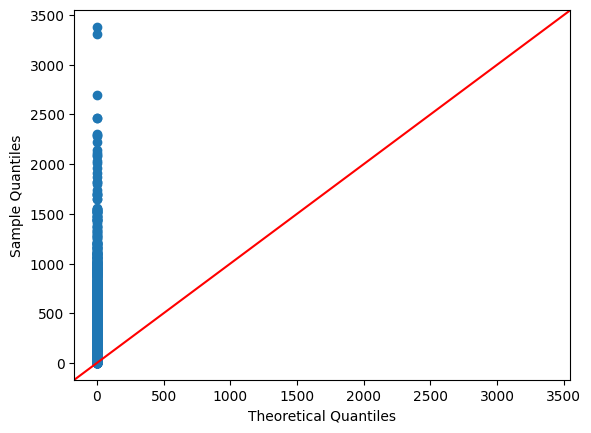

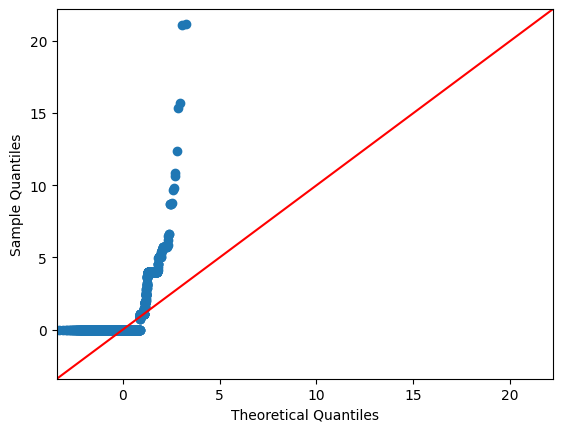

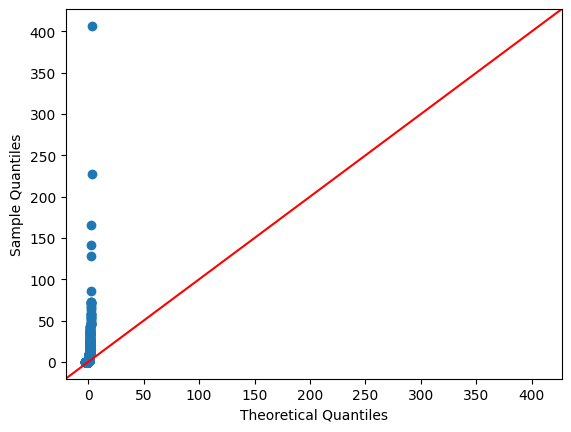

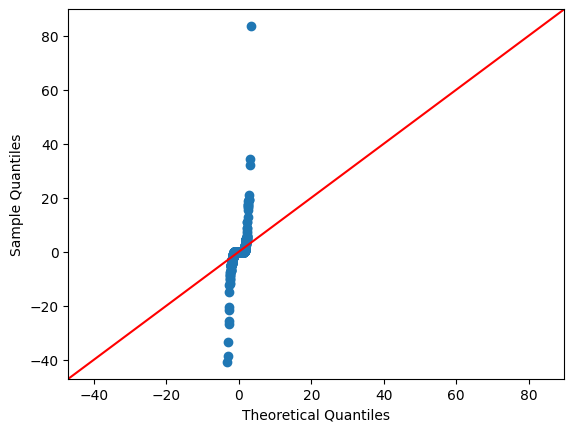

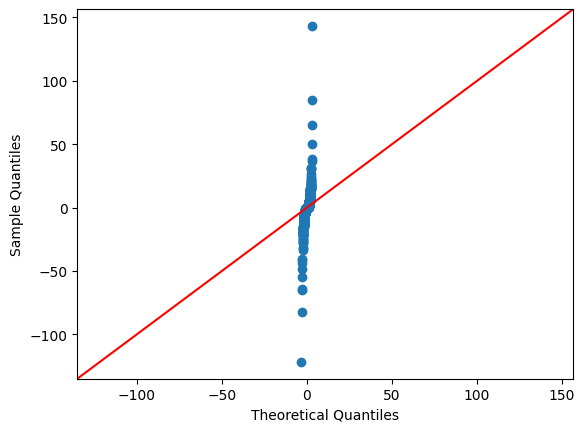

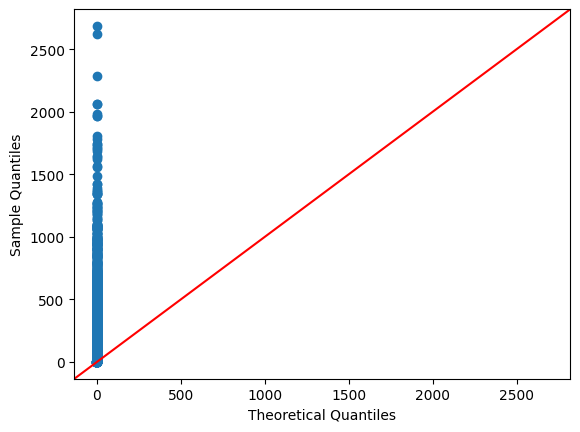

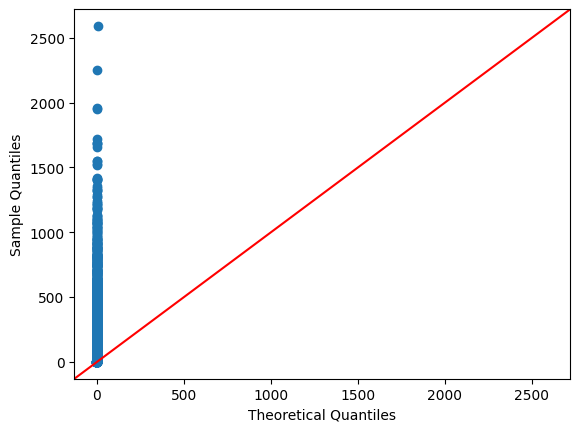

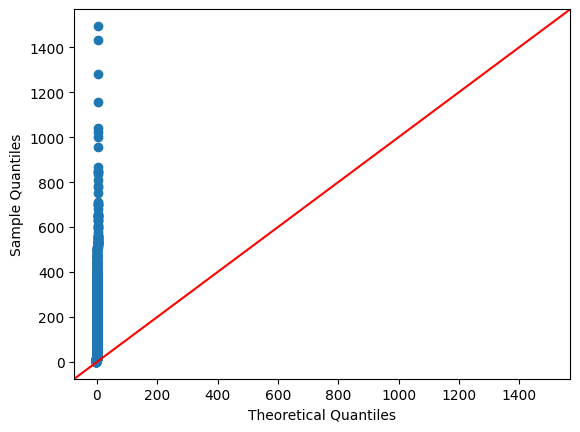

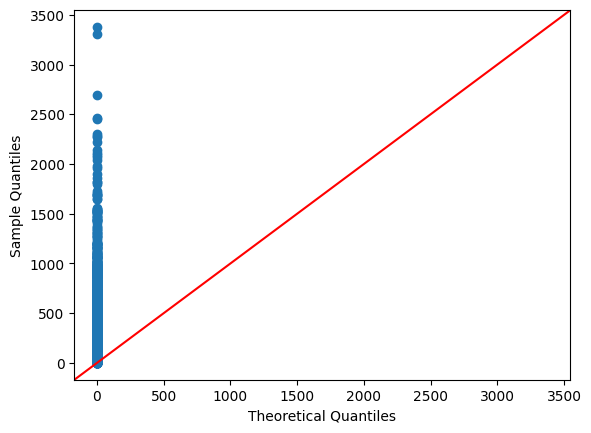

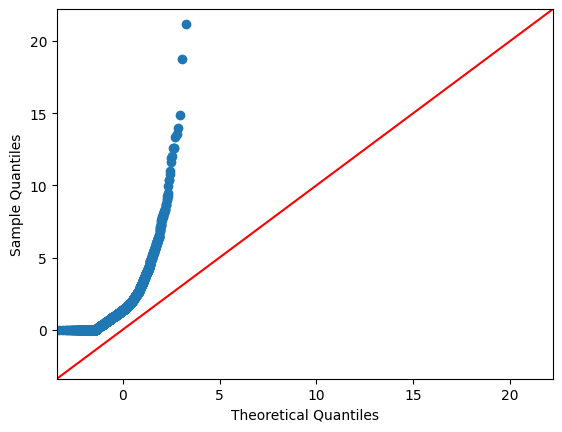

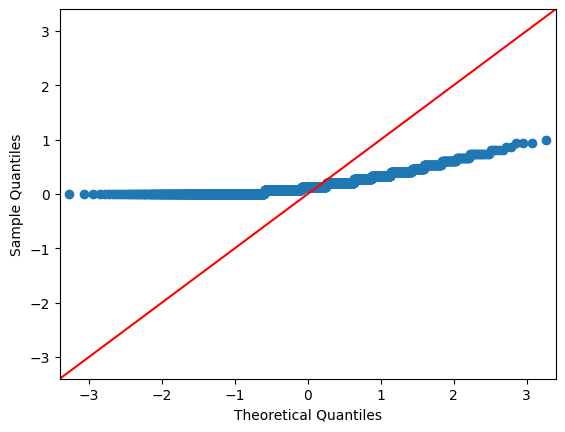

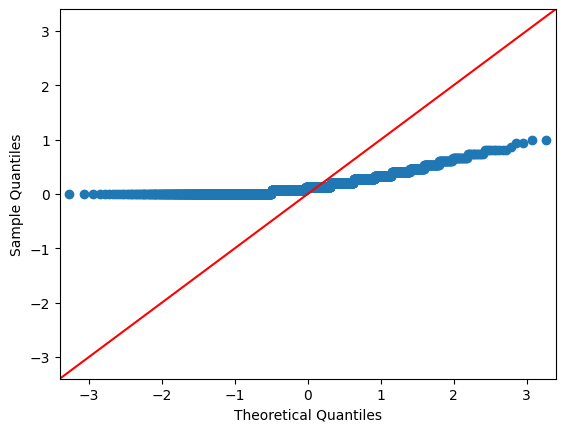

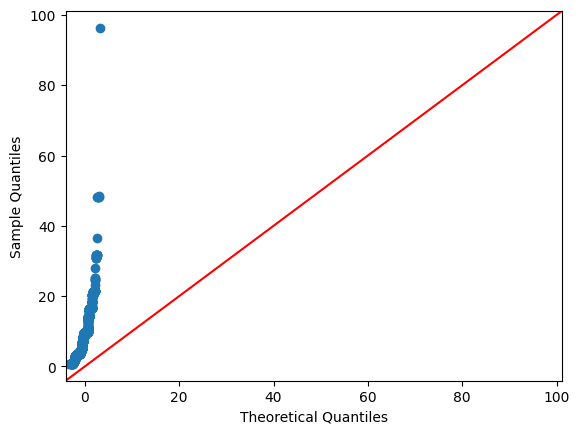

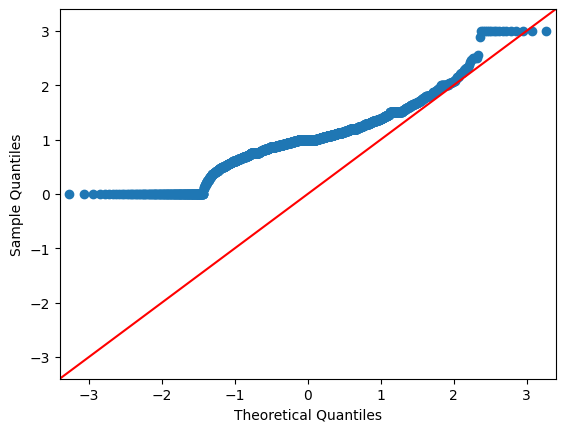

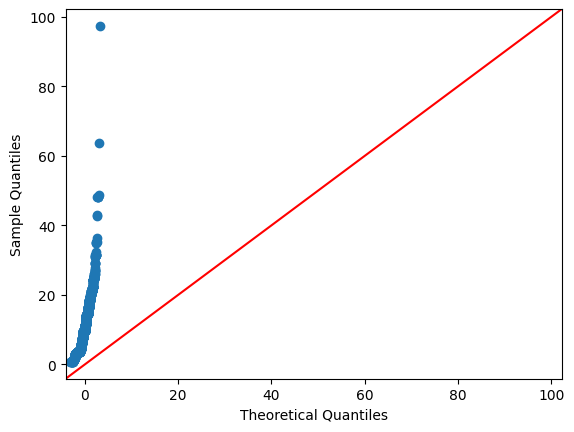

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot


data = pd.read_excel('Задания_1_2.xlsx', sheet_name='Training')
data = data.dropna()
data_0 = data.loc[data['Target'] == 0]
data_1 = data.loc[data['Target'] == 1]
for i in range(1, 32):
    qqplot(data_0[f'P{i}'],  line='45')
    plt.show()

можно наблюдать, что все данные распределены по-разному и нельзя выделить какой-то вид распредения для них. Поэтому будем опираться на модели, для которых это не очень важно. Также стоит учитывать, что у нас табличные данные. В качестве моделей для теста я выбрал CatBoost, LightGBM, а также метод опорных векторов. 

Для начала стоит поработать с признаковым пространством и уменьшить размер. Во-первых стоит попробовать исключить признаки, которые сильно коррелированы. Чтобы их обнаружить, построим тепловую карту корреляции

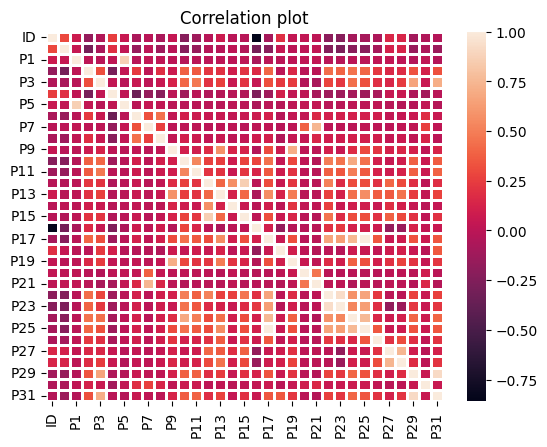

In [5]:
import seaborn as sns
corr_plot = sns.heatmap(data.corr(),linewidths=1 )
plt.title("Correlation plot")
plt.show()

далее я произвёл анализ карты и выделил 5 признаков, которые можно исключить. Однако это оказалось неэффективно, поэтому я пошёл вторым путём и воспользовался методом главных компонент

In [36]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
data = pd.read_excel('Задания_1_2.xlsx', sheet_name='Training').dropna()
#data = data.drop(columns=['P5', 'P15', 'P17', 'P21', 'P29'])
X_train, X_test, y_train, y_test = train_test_split(data.values[:, 2:], data['Target'], test_size=0.2, random_state=42)
pca = PCA(n_components=28)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

теперь сформируем модель CatBoost и обучим её. Сразу будем анализировать метрики

In [26]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
model1 = CatBoostClassifier(verbose=0, 
                            allow_writing_files=False,
                            iterations=500)
model1.fit(X_train_pca, y_train)
y_pred1 = model1.predict(X_test_pca)
y_pred_train =model1.predict(X_train_pca)
accuracy1 = accuracy_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)
print(f"f1: {f1:.2f}")
print(f"Accuracy train: {accuracy_score(y_train,y_pred_train ):.2f}")
print(f"Accuracy1: {accuracy1:.2f}")

f1: 0.71
Accuracy train: 0.92
Accuracy1: 0.70


Достаточно высокая точность на тренировочной выборке. Возможно, есть переобучение. Необходимо выделить признаки, сильнее всего влияющие на принятие решения. Для этого нам необходимо вычислить shap-значения для каждого признака. Полученные результаты пригодятся при оптимизации гиперпарметров модели

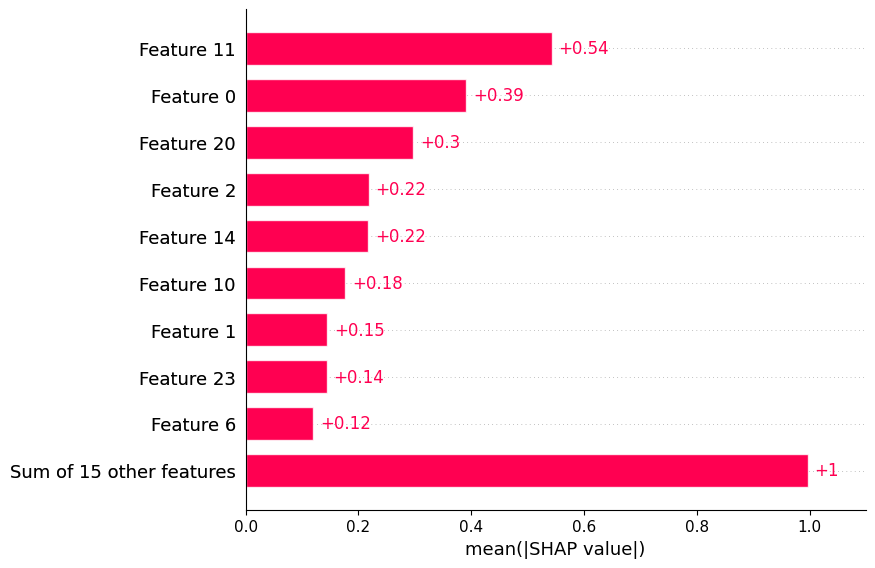

In [27]:
import shap
e = shap.Explainer(model1)
shap_values = e(X_test_pca)
shap.plots.bar(shap_values)
plt.show()

Выделим 4 признака и, согласно документации модели, добавим их к гиперпараметрам. Также добавим максимальную глубину и количество границ

In [30]:
model1 = CatBoostClassifier(verbose=0, 
                            allow_writing_files=False,
                            max_depth=4,
                            iterations=500,
                            border_count=50,
                            per_float_feature_quantization=['11:border_count=1024', '2:border_count=1024', '20:border_count=1024', '0:border_count=1024'])
model1.fit(X_train_pca, y_train)
y_pred1 = model1.predict(X_test_pca)
y_pred_train =model1.predict(X_train_pca)
accuracy1 = accuracy_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)
print(f"f1: {f1:.2f}")
print(f"Accuracy train: {accuracy_score(y_train,y_pred_train ):.2f}")
print(f"Accuracy1: {accuracy1:.2f}")

f1: 0.71
Accuracy train: 0.82
Accuracy1: 0.71


теперь построим ROC-кривую для данной модели и вычислим AUC


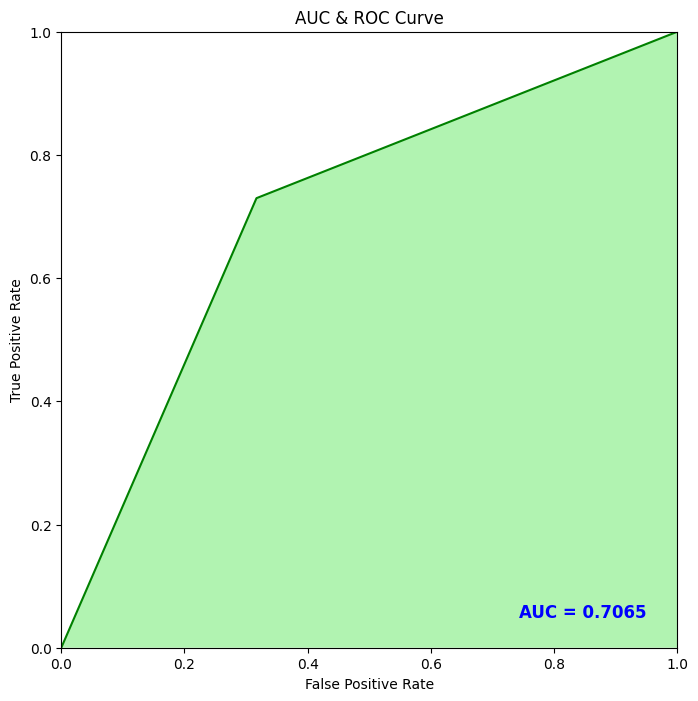

In [31]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, y_pred1)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred1)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

можно предположить, что в ходе оптимизации гиперпараметров удалось снизить переобучение и немного повысить точность

теперь попробуем воспользоваться моделью LightGBM

In [38]:
import lightgbm as lgb
train_dataset = lgb.Dataset(X_train_pca, y_train)
test_dataset = lgb.Dataset(X_test_pca, y_test)
params = {'objective': 'binary',
          'metric': 'auc',
          "boosting_type": "gbdt",
          'device_type': 'gpu',
          'early_stopping_rounds': 30}
booster1 = lgb.train(params, train_set=train_dataset, valid_sets=[test_dataset], valid_names=['valid'], num_boost_round=300)
test_predict = booster1.predict(X_test_pca)
train_predict = booster1.predict(X_train_pca)

y_pred_test = [1 if y >= 0.5 else 0 for y in test_predict]
y_pred_train = [1 if y >= 0.5 else 0 for y in train_predict]

accuracy2 = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"f1: {f1:.2f}")
print(f"Accuracy train: {accuracy_train:.2f}")
print(f"Accuracy: {accuracy2:.2f}")

[LightGBM] [Info] Number of positive: 1508, number of negative: 1465
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 2973, number of used features: 28
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 28 dense feature groups (0.08 MB) transferred to GPU in 0.003340 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507232 -> initscore=0.028929
[LightGBM] [Info] Start training from score 0.028929
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid's auc: 0.751004
f1: 0.69
Accuracy train: 0.83
Accuracy: 0.69


теперь оптимизируем гиперпараметры. Для этого я написал небольшую программу. Она автоматически перебирает данные из диапазона и выбирает лучший набор.

In [11]:
import skopt

PARAMS = {'learning_rate': 0.4,
          'max_depth': 15,
          'num_leaves': 20,
          'feature_fraction': 0.8,
          'lambda_l1': 0,
          'lambda_l2': 0,
          'subsample': 0.2}

STATIC_PARAMS = {'objective': 'binary',
          'metric': 'auc',
          "boosting_type": "gbdt",
          'device_type': 'gpu',
          'early_stopping_rounds': 30}

SPACE = [
    skopt.space.Real(0.01, 0.3, name='learning_rate'),
    skopt.space.Integer(3, 8, name='max_depth'),
    skopt.space.Integer(2, 200, name='num_leaves'),
    skopt.space.Real(0.1, 1.0, name='feature_fraction'),
    skopt.space.Real(0, 3, name='lambda_l1'),
    skopt.space.Real(0, 3, name='lambda_l2'),
    skopt.space.Real(0.1, 1.0, name='subsample')]

@skopt.utils.use_named_args(SPACE)
def objective(**params):
    all_params = {**params, **STATIC_PARAMS}
    return -1.0 * train_evaluate(all_params)

def train_evaluate(params):
    data = pd.read_excel('Задания_1_2.xlsx', sheet_name='Training')
    X_train, X_test, y_train, y_test = train_test_split(data.values[:, 2:], data['Target'], test_size=0.2, random_state=42)

    train_dataset = lgb.Dataset(X_train, y_train, feature_name=data.columns.to_list()[2:])
    test_dataset = lgb.Dataset(X_test, y_test, feature_name=data.columns.to_list()[2:])

    booster1 = lgb.train(params, train_set=train_dataset, valid_sets=[test_dataset], valid_names=['valid'], num_boost_round=300)
    score = booster1.best_score['valid']['auc']
    return score

results = skopt.forest_minimize(objective, SPACE, n_calls=100, n_random_starts=10)
best_auc = -1.0 * results.fun
best_params = results.x

print('best result: ', best_auc)
print('best parameters: ', best_params)

[LightGBM] [Info] Number of positive: 4003, number of negative: 3997
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6429
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 31
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (0.21 MB) transferred to GPU in 0.003509 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500375 -> initscore=0.001500
[LightGBM] [Info] Start training from score 0.001500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

теперь сформируем модель с учётом гиперпараметров

In [39]:
params = {'objective': 'binary',
          'metric': 'auc',
          "boosting_type": "gbdt",
          'device_type': 'gpu',
          'early_stopping_rounds': 30,
          'learning_rate': 0.25812672268269216,
          'max_depth': 7,
          'num_leaves': 11,
          'feature_fraction':  0.18612843414864266,
          'lambda_l1': 0.11399486502792223,
          'lambda_l2': 1.7437955143147326,
          'subsample': 0.716796112786919}

booster1 = lgb.train(params, train_set=train_dataset, valid_sets=[test_dataset], valid_names=['valid'], num_boost_round=300)
test_predict = booster1.predict(X_test_pca)
train_predict = booster1.predict(X_train_pca)

y_pred_test = [1 if y > 0.5 else 0 for y in test_predict]
y_pred_train = [1 if y > 0.5 else 0 for y in train_predict]

accuracy2 = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"f1: {f1:.2f}")
print(f"Accuracy train: {accuracy_train:.2f}")
print(f"Accuracy: {accuracy2:.2f}")

[LightGBM] [Info] Number of positive: 1508, number of negative: 1465
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 2973, number of used features: 28
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 28 dense feature groups (0.08 MB) transferred to GPU in 0.004076 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507232 -> initscore=0.028929
[LightGBM] [Info] Start training from score 0.028929
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid's auc: 0.748045
f1: 0.70
Accuracy train: 0.81
Accuracy: 0.71


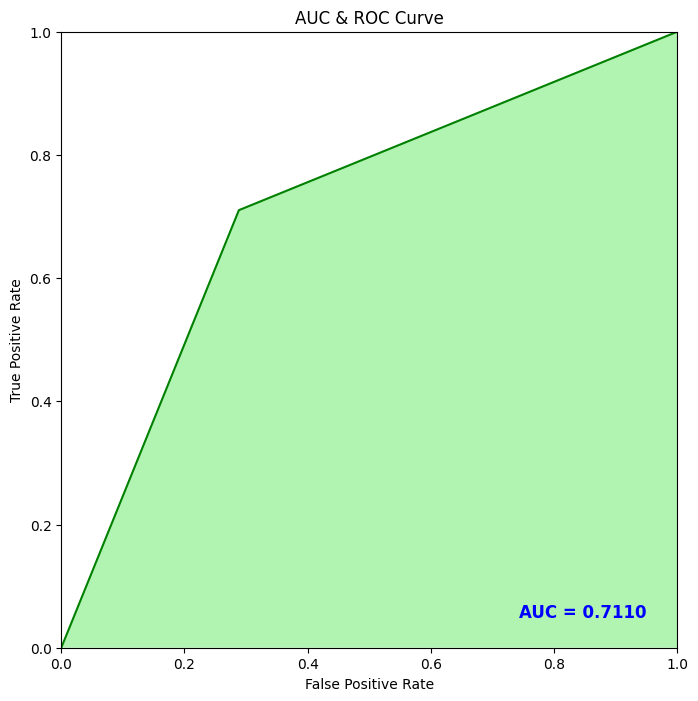

In [40]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, y_pred_test)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred_test)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

подбор гиперпараметров результата не дал. Теперь протестируем метод опорных векторов

f1: 0.67
Accuracy4: 0.67


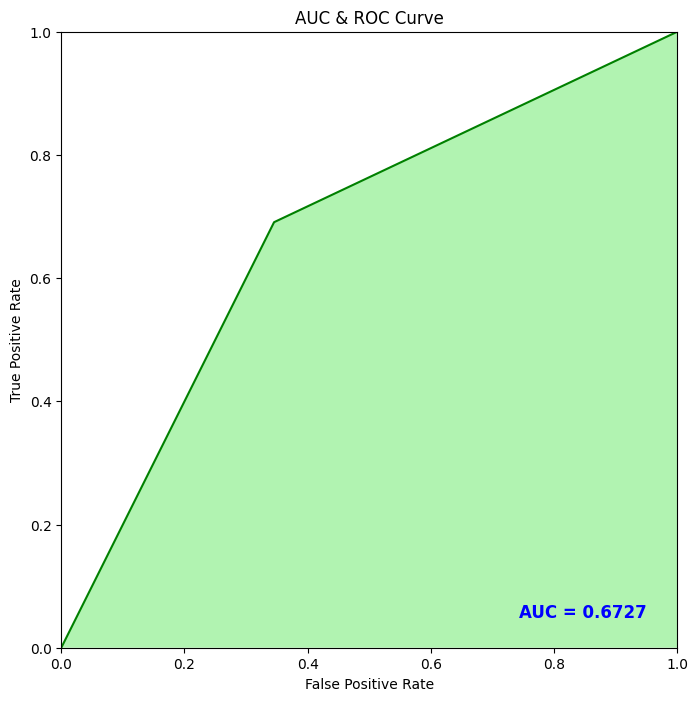

In [ ]:
from sklearn.svm import SVC
model3 = SVC(kernel='rbf', C=100, gamma='scale', random_state=42, class_weight='balanced')
model3.fit(X_train_pca, y_train)
y_pred_svc = model3.predict(X_test_pca)
f1 = f1_score(y_test, y_pred_svc)
accuracy4 = accuracy_score(y_test, y_pred_svc)
print(f"f1: {f1:.2f}")
print(f"Accuracy4: {accuracy4:.2f}") 

auc = metrics.roc_auc_score(y_test, y_pred_svc)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred_svc)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Теперь попробуем использовать модель MLP в сочетании с PCA 

Epoch 1/200


c:\Users\baran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5711 - loss: 0.6839
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6841 - loss: 0.5962
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6926 - loss: 0.5913
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7001 - loss: 0.5944
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7065 - loss: 0.5617
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7290 - loss: 0.5460
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7414 - loss: 0.5387
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7168 - loss: 0.5517
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7552 - loss: 0.5252
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7310 - loss: 0.5518
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.5117
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7379 - lo

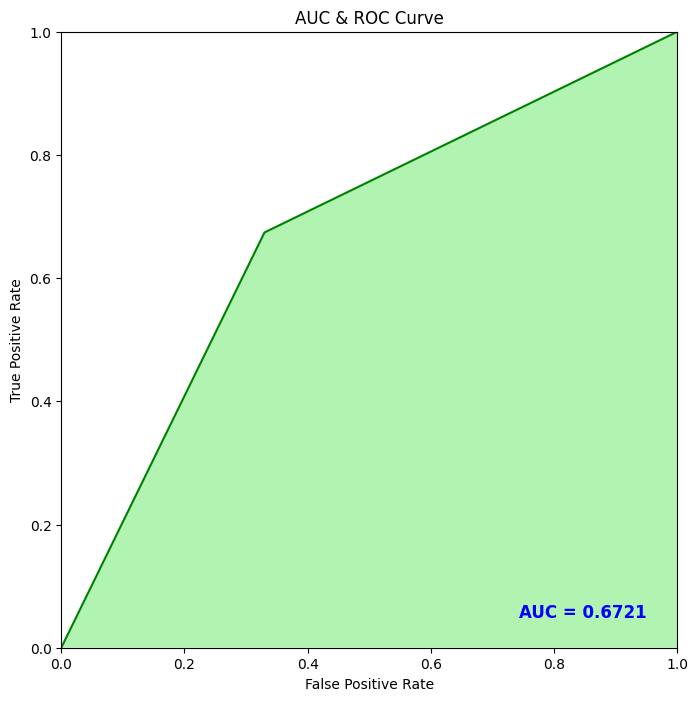

In [107]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Импорт компонентов Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

data = pd.read_excel('Задания_1_2.xlsx', sheet_name='Training').dropna()

X_train, X_test, y_train, y_test = train_test_split(data.values[:, 2:], data['Target'], test_size=0.2, random_state=42)
pca = PCA(n_components=24)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  
    Dropout(0.5),  
    Dense(64, activation='relu'),  
    Dense(1, activation='sigmoid')    
])


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train,
    y_train,
    epochs=200,
)


y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Попробуем использовать логистическую регрессию

c:\Users\baran\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Test Accuracy: 0.7016129032258065


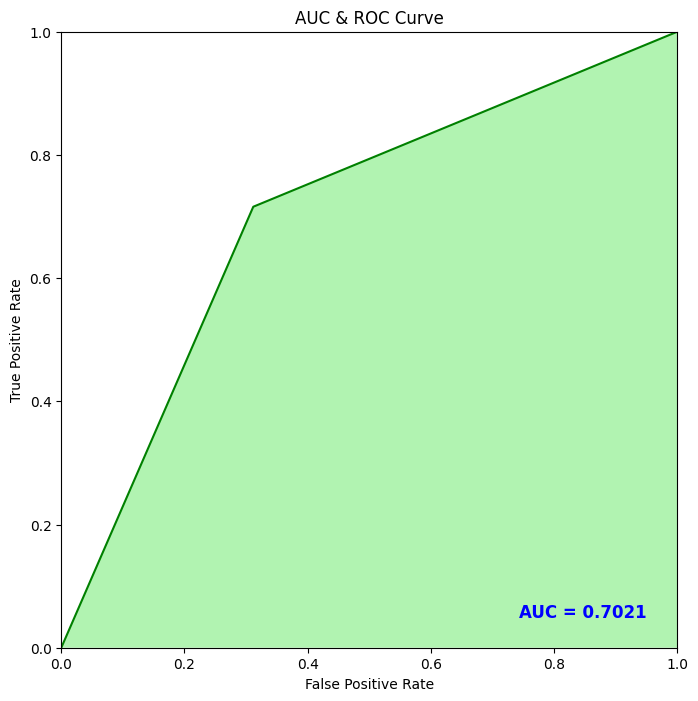

In [106]:
from sklearn.linear_model import LogisticRegression

data = pd.read_excel('Задания_1_2.xlsx', sheet_name='Training').dropna()
#data = data.drop(columns=['P5', 'P15', 'P17', 'P21', 'P29'])
X_train, X_test, y_train, y_test = train_test_split(data.values[:, 2:], data['Target'], test_size=0.2, random_state=42)
pca = PCA(n_components=28)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
log_model = LogisticRegression(C=100, class_weight='balanced', random_state=42,max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Остановимся на модели CatBoostClassifier

In [67]:
data_pred = pd.read_excel('Задания_1_2.xlsx', sheet_name='Validate').drop(columns=['ID', 'Target']).dropna()
pca = PCA(n_components=24)
X_train_pca = pca.fit_transform(data.values[:, 2:])
X_test_pca = pca.transform(data_pred.values)
y_train = data['Target']

#CatBoost n_components=24
model1 = CatBoostClassifier(verbose=0, 
                            allow_writing_files=False,
                            max_depth=4,
                            iterations=500,
                            border_count=50,
                            per_float_feature_quantization=['11:border_count=1024', '14:border_count=1024', '20:border_count=1024', '0:border_count=1024']
                )
model1.fit(X_train_pca, y_train)
y_pred = model1.predict(X_test_pca)